In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

ETL dataset

In [21]:
# Read a CSV file into a DataFrame
csv_file_path = "../Dataset/XRPUSDT/XRPUSDT_5min.csv"  # Replace with your CSV file path
xrp_df = pd.read_csv(csv_file_path)

xrp_df['timestamp'] = pd.to_datetime(xrp_df['timestamp'])
xrp_df = xrp_df[xrp_df['timestamp'].dt.year >= 2025]

In [22]:
def getATR(df, period):
    # Calculate the True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = abs(df['high'] - df['close'].shift())
    df['low_close'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Calculate the Average True Range (ATR) with Wilder's method 
    df['atr'] = df['tr'].ewm(alpha=1/period, adjust=False).mean()

    return df

In [23]:
def getADX(df, period):
    high = df['high']
    low  = df['low']

    up_move = high.diff()
    down_move = -low.diff()

    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((up_move < down_move) & (down_move > 0), down_move, 0.0)


    df = getATR(df.copy(), period)

    plus_dm_ewm = pd.Series(plus_dm, index=df.index).ewm(alpha=1/period, adjust=False).mean()
    minus_dm_ewm = pd.Series(minus_dm, index=df.index).ewm(alpha=1/period, adjust=False).mean()

    plus_di = 100 * (plus_dm_ewm / df['atr'])
    minus_di = 100 * (minus_dm_ewm / df['atr'])

    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()

    return plus_di, minus_di, adx, df['atr']


In [24]:
tp = 2
sl = 1

trend_df = pd.DataFrame()

trend_df['timestamp'] = xrp_df['timestamp']

#SMA
trend_df['SMA_fast'] = xrp_df['close'].rolling(window=5).mean()
trend_df['SMA_slow'] = xrp_df['close'].rolling(window=20).mean()

#MACD
trend_df['EMA_fast'] = xrp_df['close'].ewm(span=12, adjust=False).mean()
trend_df['EMA_slow'] = xrp_df['close'].ewm(span=26, adjust=False).mean()
trend_df['MACD'] = trend_df['EMA_fast'] - trend_df['EMA_slow']
trend_df['Signal_Line'] = trend_df['MACD'].ewm(span=9, adjust=False).mean()

#ADX
adx = getADX(xrp_df, 14)
trend_df['plus_di'] = pd.DataFrame(adx[0]).rename(columns = {0:'plus_di'})
trend_df['minus_di'] = pd.DataFrame(adx[1]).rename(columns = {0:'minus_di'})
trend_df['adx'] = pd.DataFrame(adx[2]).rename(columns = {0:'adx'})
trend_df['take_profit'] = tp * getADX(xrp_df, 14)[3]
trend_df['stop_loss'] = sl * getADX(xrp_df, 14)[3]

trend_df.dropna(inplace = True)
trend_df.reset_index(drop=True, inplace=True)


In [6]:
trend_df.head()

,timestamp,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx,take_profit,stop_loss
0,2025-01-01 01:35:00,2.10130,2.100740,2.101862,2.098143,0.003719,0.004258,23.889642,11.444314,68.095289,0.012009,0.006004
1,2025-01-01 01:40:00,2.10192,2.101670,2.102037,2.098503,0.003534,0.004113,22.587487,11.305025,65.609122,0.011794,0.005897
2,2025-01-01 01:45:00,2.10280,2.102235,2.102339,2.098910,0.003429,0.003976,21.335116,12.896028,62.683702,0.011594,0.005797
3,2025-01-01 01:50:00,2.10212,2.102215,2.101410,2.098717,0.002693,0.003720,18.946777,18.640381,58.264521,0.012123,0.006062
4,2025-01-01 01:55:00,2.10038,2.102015,2.100316,2.098389,0.001927,0.003361,17.795095,19.414307,54.413599,0.011986,0.005993


In [7]:
xrp_df.head()

,timestamp,open,high,low,close
699717,2025-01-01 00:00:00,2.0836,2.0869,2.0811,2.0844
699718,2025-01-01 00:05:00,2.0845,2.0931,2.0844,2.0927
699719,2025-01-01 00:10:00,2.0926,2.0967,2.0893,2.0967
699720,2025-01-01 00:15:00,2.0968,2.1019,2.0953,2.0983
699721,2025-01-01 00:20:00,2.0983,2.1011,2.0948,2.0974


Add Signals

In [25]:
def checkMACD(EMA_fast, EMA_slow, MACD, signal_line):
    if EMA_fast > EMA_slow and MACD > signal_line:
        return 1  # Buy signal
    elif EMA_fast < EMA_slow and MACD < signal_line:
        return -1  # Sell signal
    else:
        return 0  # No signal
    

In [26]:
def checkSMA(SMA_fast, SMA_slow):
    if SMA_fast > SMA_slow:
        return 1  # Buy signal
    elif SMA_fast < SMA_slow:
        return -1  # Sell signal
    else:
        return 0  # No signal

In [27]:
def checkADX(plus_di, minus_di, adx):
    if adx > 20 and plus_di > minus_di:
        return 1  # Buy signal
    elif adx > 20 and minus_di > plus_di:
        return -1  # Sell signal
    else:
        return 0  # No signal / Take Profit

In [28]:
def checkSignal(SMA, MACD, ADX):
    return SMA * MACD * ADX 

In [29]:
def addSignals(xrp_df, trend_df):
    xrp_df['SMA_Signal'] = trend_df.apply(lambda row: checkSMA(row['SMA_fast'], row['SMA_slow']), axis=1)
    xrp_df['MACD_Signal'] = trend_df.apply(lambda row: checkMACD(row['EMA_fast'], row['EMA_slow'], row['MACD'], row['Signal_Line']), axis=1)
    xrp_df['ADX_Signal'] = trend_df.apply(lambda row: checkADX(row['plus_di'], row['minus_di'], row['adx']), axis=1)
    
    # Combine the signals
    xrp_df['Combined_Signal'] = xrp_df.apply(lambda row: checkSignal(row['SMA_Signal'], row['MACD_Signal'], row['ADX_Signal']), axis=1)
    return xrp_df

In [30]:
trend_df = trend_df.reset_index(drop=True)
xrp_df = xrp_df.reset_index(drop=True)

xrp_df['take_profit'] = trend_df['take_profit']
xrp_df['stop_loss'] = trend_df['stop_loss']

xrp_df = addSignals(xrp_df, trend_df)

In [31]:
xrp_df.head()

,timestamp,open,high,low,close,take_profit,stop_loss,SMA_Signal,MACD_Signal,ADX_Signal,Combined_Signal
0,2025-01-01 00:00:00,2.0836,2.0869,2.0811,2.0844,0.012009,0.006004,1.0,0.0,1.0,0.0
1,2025-01-01 00:05:00,2.0845,2.0931,2.0844,2.0927,0.011794,0.005897,1.0,0.0,1.0,0.0
2,2025-01-01 00:10:00,2.0926,2.0967,2.0893,2.0967,0.011594,0.005797,1.0,0.0,1.0,0.0
3,2025-01-01 00:15:00,2.0968,2.1019,2.0953,2.0983,0.012123,0.006062,-1.0,0.0,1.0,-0.0
4,2025-01-01 00:20:00,2.0983,2.1011,2.0948,2.0974,0.011986,0.005993,-1.0,0.0,-1.0,0.0


In [32]:
trend_df.tail()

,timestamp,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx,take_profit,stop_loss
30829,2025-04-18 02:40:00,2.05724,2.058805,2.057193,2.058530,-0.001337,-0.001810,19.221769,19.348348,15.114561,0.010237,0.005118
30830,2025-04-18 02:45:00,2.05856,2.059070,2.057855,2.058750,-0.000894,-0.001627,17.853341,19.785595,14.401640,0.010234,0.005117
30831,2025-04-18 02:50:00,2.05960,2.058960,2.058278,2.058887,-0.000609,-0.001423,19.643823,18.904603,13.509926,0.009946,0.004973
30832,2025-04-18 02:55:00,2.06000,2.058865,2.058527,2.058962,-0.000435,-0.001225,18.997333,19.927970,12.715704,0.009550,0.004775
30833,2025-04-18 03:00:00,2.06032,2.058675,2.058738,2.059031,-0.000293,-0.001039,18.519961,19.427212,11.978213,0.009096,0.004548


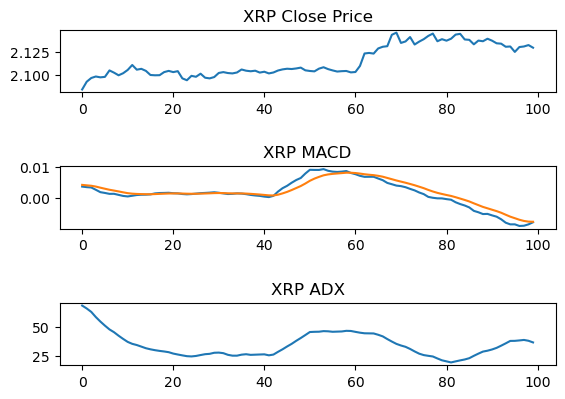

In [33]:
xrp_df_clone = xrp_df[['timestamp', 'close']][:100]
trend_df_clone = trend_df[['MACD', 'Signal_Line', 'adx']][:100]

ax = plt.subplot2grid((11,1), (0,0), rowspan = 2, colspan = 2)
ax.plot(xrp_df_clone['close'])

ax1 = plt.subplot2grid((11,1), (4,0), rowspan = 2, colspan = 2)
ax1.plot(trend_df_clone['MACD'])
ax1.plot(trend_df_clone['Signal_Line'])

ax2 = plt.subplot2grid((11,1), (8,0), rowspan = 2, colspan = 2)  
ax2.plot(trend_df_clone['adx'])

ax.set_title('XRP Close Price')
ax1.set_title('XRP MACD')
ax2.set_title('XRP ADX')
plt.show()

In [18]:
trend_df.head(200)

,timestamp,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx,take_profit,stop_loss
0,2025-01-01 01:35:00,2.10130,2.100740,2.101862,2.098143,0.003719,0.004258,23.889642,11.444314,68.095289,0.012009,0.006004
1,2025-01-01 01:40:00,2.10192,2.101670,2.102037,2.098503,0.003534,0.004113,22.587487,11.305025,65.609122,0.011794,0.005897
2,2025-01-01 01:45:00,2.10280,2.102235,2.102339,2.098910,0.003429,0.003976,21.335116,12.896028,62.683702,0.011594,0.005797
3,2025-01-01 01:50:00,2.10212,2.102215,2.101410,2.098717,0.002693,0.003720,18.946777,18.640381,58.264521,0.012123,0.006062
4,2025-01-01 01:55:00,2.10038,2.102015,2.100316,2.098389,0.001927,0.003361,17.795095,19.414307,54.413599,0.011986,0.005993
5,2025-01-01 02:00:00,2.09932,2.102095,2.100114,2.098435,0.001679,0.003025,19.768112,17.730245,50.915096,0.012187,0.006094
6,2025-01-01 02:05:00,2.09832,2.102100,2.099788,2.098402,0.001386,0.002697,18.795314,16.857731,47.666485,0.011902,0.005951
7,2025-01-01 02:10:00,2.09778,2.101925,2.100021,2.098617,0.001404,0.002438,21.053853,15.834369,45.272412,0.011766,0.005883
8,2025-01-01 02:15:00,2.09792,2.101655,2.099556,2.098497,0.001059,0.002162,19.475094,18.154445,42.289354,0.011812,0.005906
9,2025-01-01 02:20:00,2.09832,2.101490,2.099055,2.098335,0.000721,0.001874,18.261996,19.710617,39.541180,0.011697,0.005848


Base Strategy Backtest

In [34]:
initial_investment = 200
investment_per_trade = 200
total_investment_amount = 200
entry_price = 0
current_shares = 0 
profit = 0
hold = False
signal = None
signal_list = []

total_trades = 0
errors = 0

for i in range(len(xrp_df)):
    row = xrp_df.iloc[i]
    current_price = row['close']

    # No position held
    if not hold:
        if row['Combined_Signal'] == 1:  # Buy signal
            signal = "buy"
            entry_price = current_price
            current_shares = investment_per_trade / entry_price  
            hold = True
            total_trades += 1
            signal_list.append("buy")
        elif row['Combined_Signal'] == -1:  # Sell signal
            signal = "sell"
            entry_price = current_price
            current_shares = investment_per_trade / entry_price  
            hold = True
            total_trades += 1
            signal_list.append("sell")
        else:
            signal_list.append("skip")
    
    # When holding a position
    else:  
        # Calculate profit or loss
        if signal == "buy":
            profit = (current_price - entry_price) * current_shares 
        elif signal == "sell":
            profit = (entry_price - current_price) * current_shares

        # Check take profit and stop loss conditions
        if profit >= row['take_profit'] or profit <= row['stop_loss']:
            total_investment_amount += profit  # Update investment amount with the profit or loss from this trade
            if profit < 0:
                errors += 1
            hold = False  # Exit the position
            profit = 0  # Reset after trade is closed
            signal_list.append("take profit")
        else:
            signal_list.append("hold")

    xrp_df.loc[i, 'investment_overtime'] = total_investment_amount  # Track investment over time

    
    # Check how much to trade
    if total_investment_amount < investment_per_trade:
        investment_per_trade = total_investment_amount
    else: investment_per_trade = 200

    # Check if investment is depleted
    if total_investment_amount <= 0:
        print(f"Investment depleted at iteration {i} on {xrp_df['timestamp'].iloc[i]}")
        break

# Fill remaining signal list if necessary
if len(signal_list) < len(xrp_df):
    signal_list.extend(["skip"] * (len(xrp_df) - len(signal_list)))

xrp_df['signal'] = signal_list


In [40]:
xrp_df.tail(100)

,timestamp,open,high,low,close,take_profit,stop_loss,SMA_Signal,MACD_Signal,ADX_Signal,Combined_Signal,investment_overtime,signal
30753,2025-04-17 18:45:00,2.0948,2.0953,2.0854,2.0879,0.013631,0.006816,1.0,0.0,-1.0,-0.0,520.350439,skip
30754,2025-04-17 18:50:00,2.0880,2.0888,2.0832,2.0867,0.013029,0.006514,1.0,0.0,-1.0,-0.0,520.350439,skip
30755,2025-04-17 18:55:00,2.0867,2.0867,2.0798,2.0800,0.013213,0.006606,1.0,0.0,1.0,0.0,520.350439,skip
30756,2025-04-17 19:00:00,2.0799,2.0835,2.0794,2.0826,0.013112,0.006556,1.0,0.0,-1.0,-0.0,520.350439,skip
30757,2025-04-17 19:05:00,2.0825,2.0866,2.0809,2.0811,0.013018,0.006509,1.0,0.0,-1.0,-0.0,520.350439,skip
30758,2025-04-17 19:10:00,2.0811,2.0824,2.0744,2.0759,0.013145,0.006573,1.0,0.0,-1.0,-0.0,520.350439,skip
30759,2025-04-17 19:15:00,2.0759,2.0762,2.0568,2.0595,0.012506,0.006253,1.0,0.0,0.0,0.0,520.350439,skip
30760,2025-04-17 19:20:00,2.0595,2.0611,2.0524,2.0576,0.012327,0.006164,1.0,0.0,0.0,0.0,520.350439,skip
30761,2025-04-17 19:25:00,2.0575,2.0638,2.0571,2.0585,0.011947,0.005973,1.0,0.0,0.0,0.0,520.350439,skip
30762,2025-04-17 19:30:00,2.0585,2.0631,2.0551,2.0558,0.011551,0.005775,1.0,0.0,0.0,0.0,520.350439,skip


In [35]:
investment_value = 200
profit_percentage = math.floor((total_investment_amount/initial_investment)*100)
error_percentage = 0
if errors > 0:
    error_percentage = math.floor(errors/total_trades * 100)

print("Profit gained from the strategy by investing P200 in XRP : " + str(round(total_investment_amount, 2)))
print("Profit percentage of the strategy : " + str(profit_percentage))
print("Total Trades: ", total_trades)
print("Errors: ", errors)
print("Error Percentage: ", error_percentage, "%")

Profit gained from the strategy by investing P200 in XRP : 520.52
Profit percentage of the strategy : 260
Total Trades:  5765
Errors:  2730
Error Percentage:  47 %


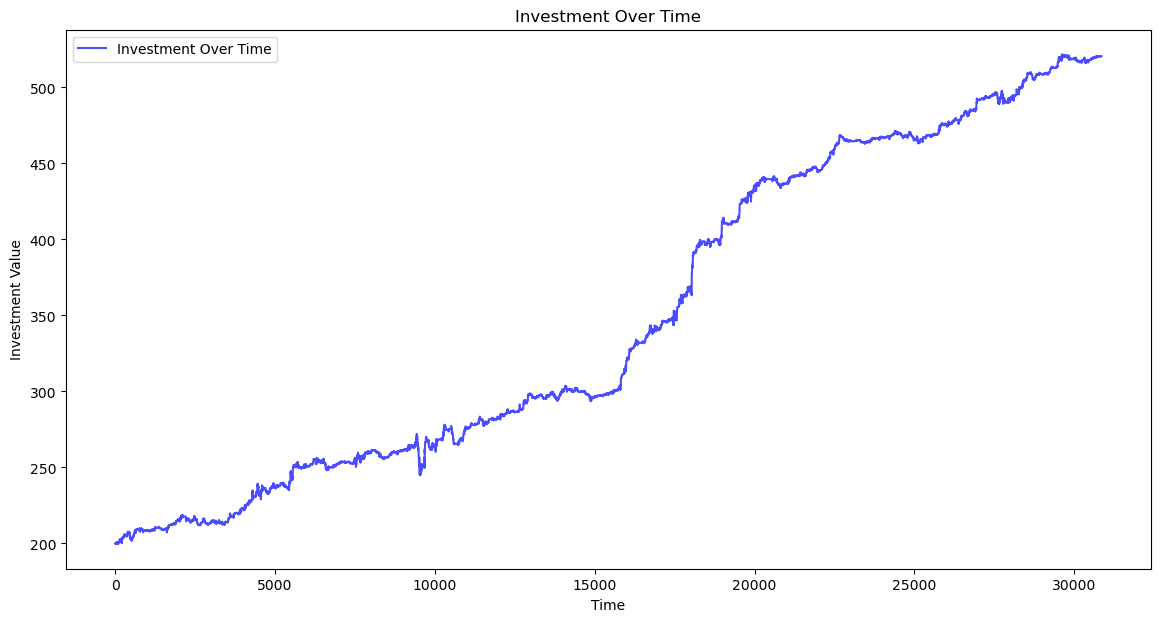

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(xrp_df['investment_overtime'], label="Investment Over Time", color="blue", alpha=0.7)
plt.title("Investment Over Time")
plt.xlabel("Time")
plt.ylabel("Investment Value")
plt.legend()
plt.show()